In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow import keras

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=False)

Dropped 25 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
from sklearn.preprocessing import StandardScaler

# Split first to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def optimize_hyperparameters_rfr(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 150, 200, 350, 300],
    }
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

def train_optimized_family_models(df, model):
    optimized_models = {}
    families = list(df['steel_family'].unique())
    for family in tqdm(families, desc="Optimizing Models", unit="family"):
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model == 'rfr':
            optimization_results = optimize_hyperparameters_rfr(X_train, y_train)
        elif model == 'xgb':
            optimization_results = optimize_hyperparameters_xgb(X_train, y_train)
        elif model == 'gpr':
            optimization_results = optimize_hyperparameters_gpr(X_train, y_train)
        elif model == 'knn':
            optimization_results = optimize_hyperparameters_knn(X_train, y_train)
        elif model == 'svr':
            optimization_results = optimize_hyperparameters_svr(X_train, y_train)
        elif model == 'ridge':
            optimization_results = optimize_hyperparameters_ridge(X_train, y_train)
        else:
            raise ValueError(f"Unsupported model type: {model}")
        
        best_model = optimization_results['best_estimator']
        best_model.fit(X_train, y_train)
        
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        optimized_models[family] = {
            'model': best_model,
            'best_params': optimization_results['best_params'],
            'best_score': optimization_results['best_score'],
            'train_mse': mean_squared_error(y_train, y_pred_train),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test)
        }
    return optimized_models

In [5]:
# Run optimization
optimized_family_models = train_optimized_family_models(train_scaled_df, model='rfr')

for family, model_info in optimized_family_models.items():
    print(f"Family: {family}")
    print(f"Best Parameters: {model_info['best_params']}")
    print(f"Best CV Score (MSE): {model_info['best_score']}")
    print(f"Test MSE: {model_info['test_mse']}")
    print(f"Test R2: {model_info['test_r2']}")

Optimizing Models: 100%|██████████| 3/3 [02:24<00:00, 48.31s/family]

Family: HSLA
Best Parameters: {'n_estimators': 350}
Best CV Score (MSE): 0.10422882752659104
Test MSE: 0.02194601984891604
Test R2: 0.7637555142654998
Family: IF
Best Parameters: {'n_estimators': 300}
Best CV Score (MSE): 0.2339779207613027
Test MSE: 0.08998169497477014
Test R2: 0.5421189067565122
Family: CMn
Best Parameters: {'n_estimators': 200}
Best CV Score (MSE): 0.15543521309277675
Test MSE: 0.047941483250517544
Test R2: 0.6524220604446704


In [6]:
def tol90(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return np.percentile(errors, 90)

def plot_predicted_vs_actual(optimized_models, df):
    plt.figure(figsize=(15, 5 * len(optimized_models)))
    
    for i, (family, model_info) in enumerate(optimized_models.items(), 1):
        plt.subplot(len(optimized_models), 1, i)
        
        # Recreate train/test split
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Predict
        y_pred_test = model_info['model'].predict(X_test)
        
        # Calculate tol90
        tol90_value = tol90(y_test, y_pred_test)
        
        # Plot scatter
        plt.scatter(y_test, y_pred_test, alpha=0.7, label='Predictions')
        
        # Plot perfect prediction line
        min_val = min(y_test.min(), y_pred_test.min())
        max_val = max(y_test.max(), y_pred_test.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Plot tolerance lines
        plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value], 'g--', lw=1.5, label=f'+tol90 ({tol90_value:.4f})')
        plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value], 'b--', lw=1.5, label=f'-tol90 ({tol90_value:.4f})')
        
        # Titles and labels
        plt.title(f'{family} - Predicted vs Actual R-Value')
        plt.xlabel('Actual R-Value')
        plt.ylabel('Predicted R-Value')
        
        # Annotate with R², MSE, and tol90
        plt.text(0.05, 0.95, 
                 f"Test R²: {model_info['test_r2']:.4f}\n" +
                 f"Test MSE: {model_info['test_mse']:.4f}\n" +
                 f"Test tol90: {tol90_value:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
        
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()



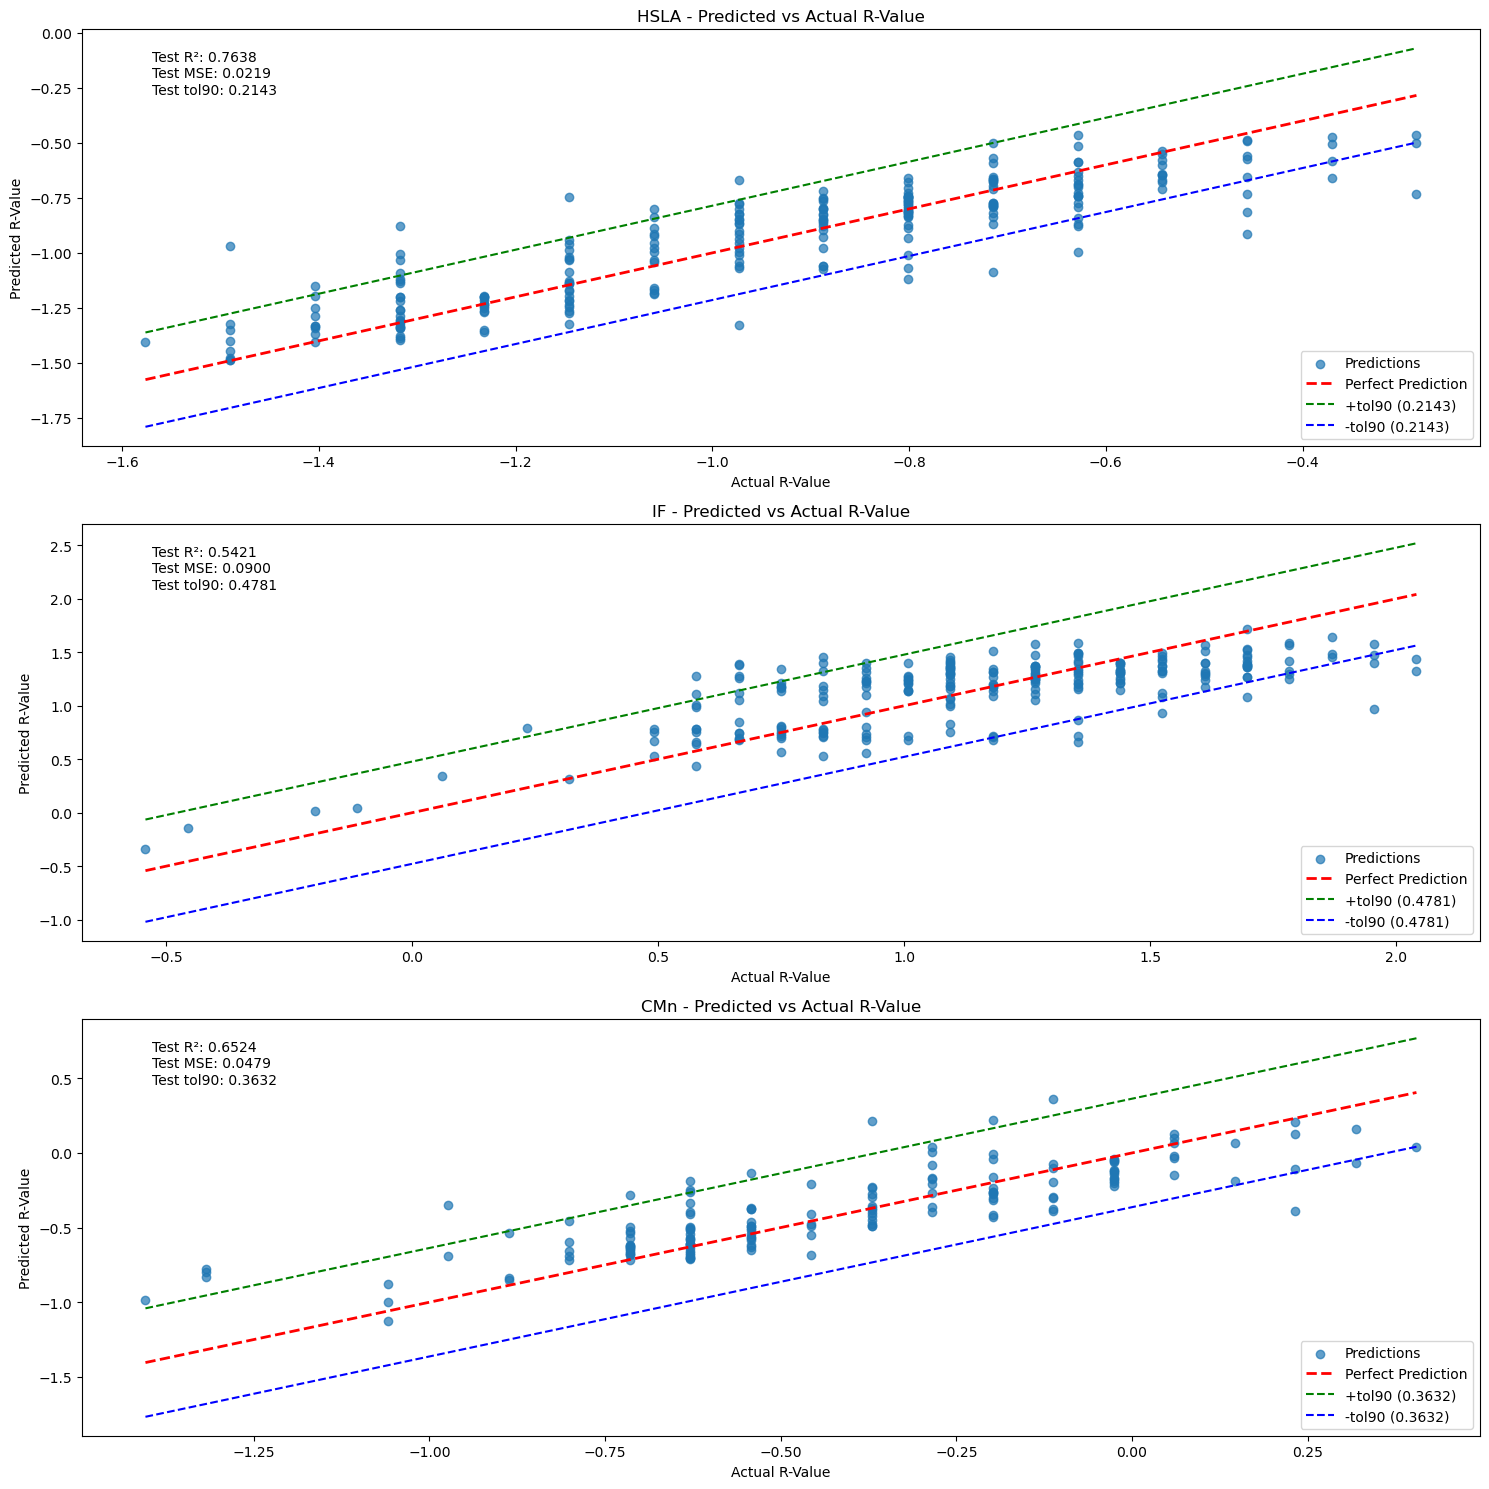

In [7]:
plot_predicted_vs_actual(optimized_family_models, test_scaled_df)

XGB -----

In [ ]:
def optimize_hyperparameters_xgb(X_train, y_train):

    param_grid = {
        'eta': [0.01, 0.1, 0.3],
        'lambda': [0, 0.1, 1, 10],
        'max_depth': [3, 4, 5, 6]
    }
    
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

In [9]:
trained_models_xgb = train_optimized_family_models(train_scaled_df, model='xgb')

Optimizing Models: 100%|██████████| 3/3 [00:17<00:00,  5.89s/family]


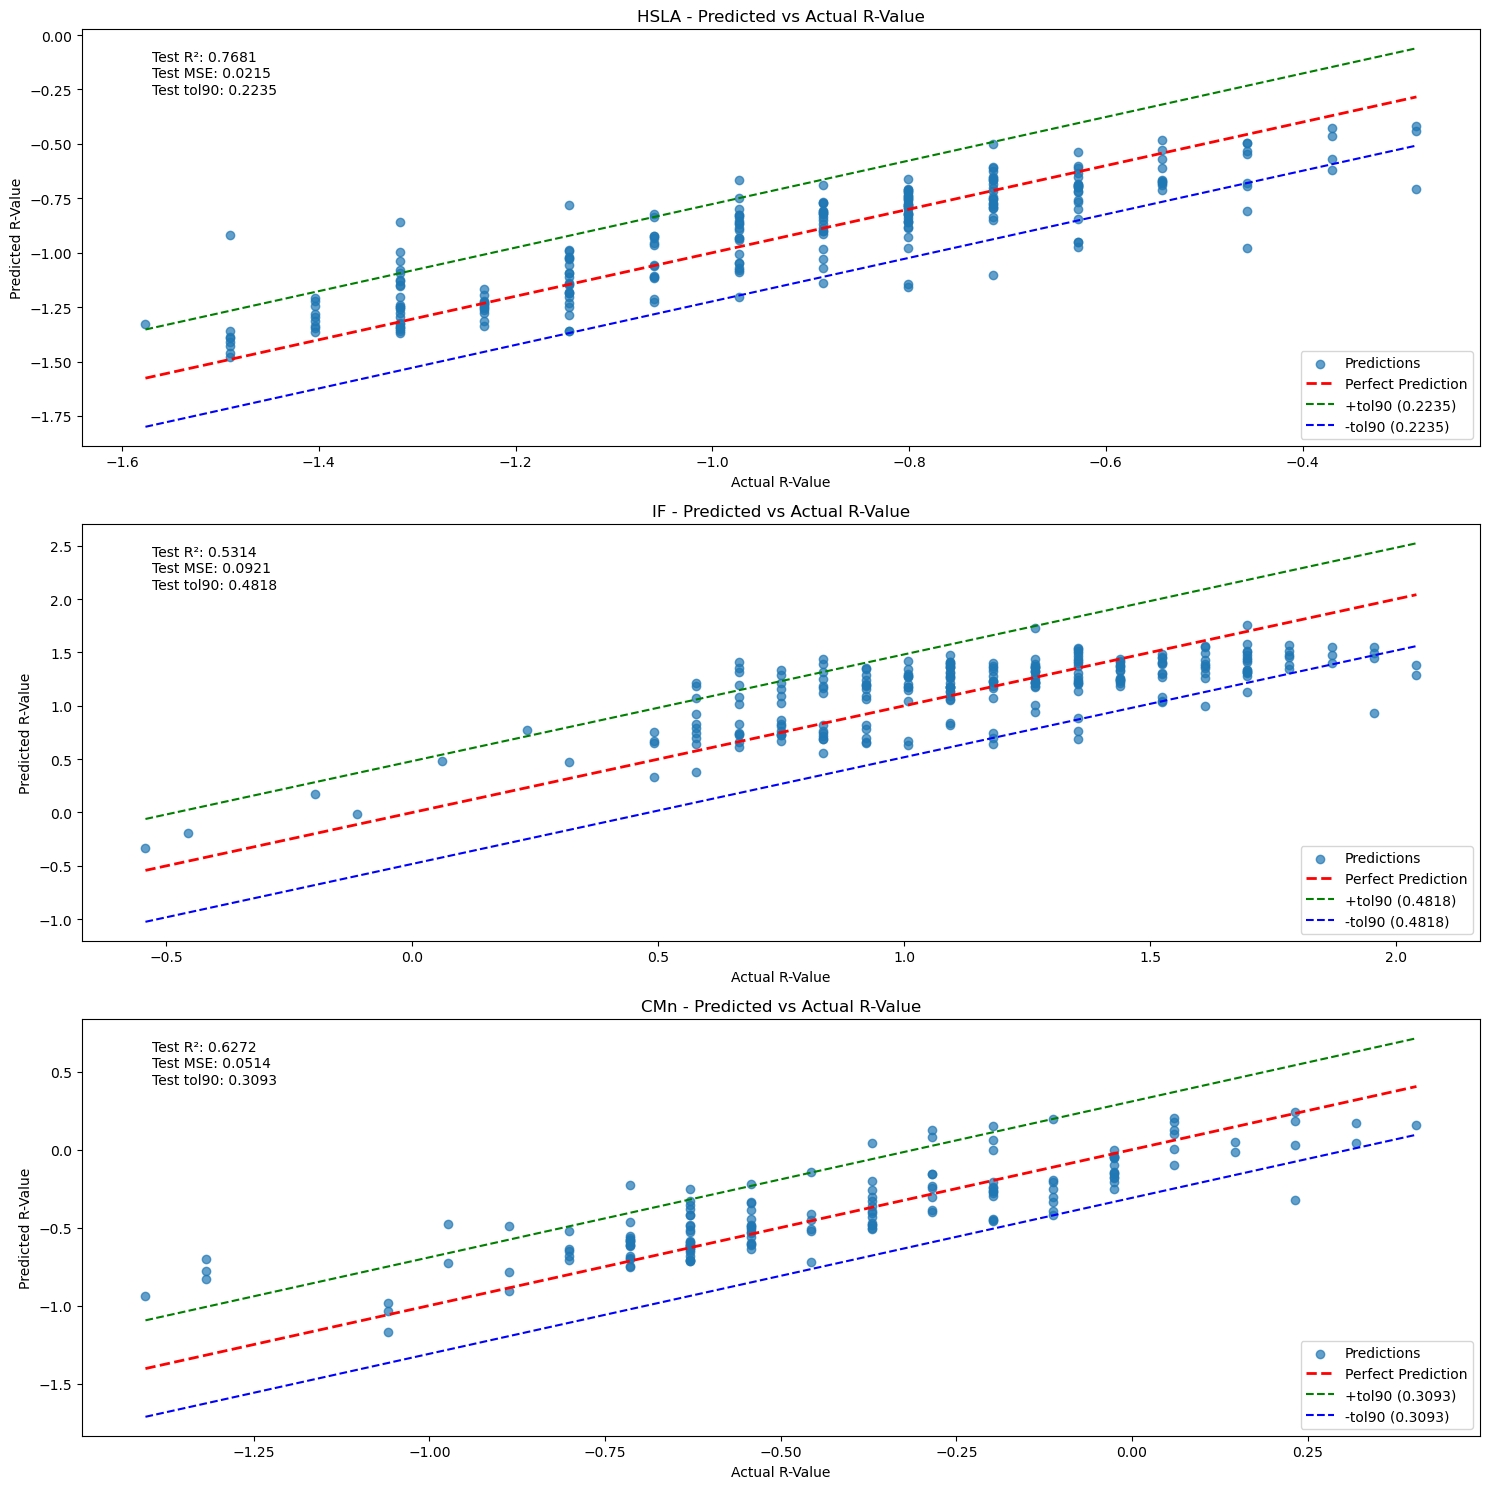

In [10]:
plot_predicted_vs_actual(trained_models_xgb, test_scaled_df)

ANN---- (from Millner paper)

In [27]:
class SteelPropertiesANN:
    def __init__(self, input_dim, target_column):
        self.input_dim = input_dim
        self.target_column = target_column
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')
        self.scaler = None

    def build_model(self, config):

        hidden_layers = config['layers']
        learning_rate = config['learning_rate']
        l2_strength = config['l2_regularization']
        
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_dim,)))
        
        for units, activation in hidden_layers:
            model.add(keras.layers.Dense(
                units=units,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(l2_strength)
            ))
        
        model.add(keras.layers.Dense(1))
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=0.9,
            staircase=True
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='mean_absolute_error',
            metrics=['mae']
        )
        return model

    def generate_grid_configs(self, 
        layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
        layer_depths=[2, 3, 4],
        learning_rates=[1e-2, 1e-3, 1e-4],
        l2_regularization=[1e-3, 1e-4, 1e-5],
        batch_sizes=[16, 32, 64]
    ):
        """
        Generate comprehensive grid search configurations
        :return: List of configuration dictionaries
        """
        from itertools import product
        grid_configs = []
        
        for depth in layer_depths:
            for lr in learning_rates:
                for l2_reg in l2_regularization:
                    for batch_size in batch_sizes:
                        layer_combinations = list(product(layer_options, repeat=depth))
                        for layers in layer_combinations:
                            config = {
                                'layers': layers,
                                'learning_rate': lr,
                                'l2_regularization': l2_reg,
                                'batch_size': batch_size
                            }
                            grid_configs.append(config)
        
        return grid_configs

    def grid_search(self, train_scaled_df, epochs=100, max_configs=None):
        """
        Perform comprehensive grid search
        :param train_scaled_df: Training DataFrame
        :param test_scaled_df: Test DataFrame (not used during training)
        :param epochs: Number of training epochs
        :param max_configs: Limit number of configurations to test
        :return: Best model and best parameters
        """
        # Split training data into training and validation sets
        train_data, val_data = train_test_split(train_scaled_df, test_size=0.2, random_state=42)
        
        X_train = train_data.drop(['steel_family', self.target_column], axis=1).values
        y_train = train_data[self.target_column].values
        X_val = val_data.drop(['steel_family', self.target_column], axis=1).values
        y_val = val_data[self.target_column].values
        
        grid_configs = self.generate_grid_configs(
            layer_options=[(32, 'relu'), (64, 'relu')],
            layer_depths=[2],
            learning_rates=[1e-3],
            l2_regularization=[1e-4],
            batch_sizes=[32]
        )
        
        if max_configs:
            grid_configs = grid_configs[:max_configs]
        
        results = []
        for config in grid_configs:
            tf.keras.backend.clear_session()
            model = self.build_model(config)
            batch_size = min(config['batch_size'], len(X_train))
            
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True,
                min_delta=1e-4
            )
            
            try:
                model.fit(
                    X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                
                result_entry = config.copy()
                result_entry.update({'val_loss': val_loss})
                results.append(result_entry)
                
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_model = model
                    self.best_params = config
                
            except Exception as e:
                pass
        
        return self.best_model, self.best_params

    def evaluate(self, test_scaled_df):
        """
        Evaluate the best model
        :param test_scaled_df: Test DataFrame (used only after model selection)
        :return: Evaluation metrics
        """
        if self.best_model is None:
            raise ValueError("No model has been trained. Call grid_search first.")
        
        X_test = test_scaled_df.drop(['steel_family', self.target_column], axis=1).values
        y_test = test_scaled_df[self.target_column].values
        
        y_pred = self.best_model.predict(X_test).flatten()
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        return {
            'MSE': mse,
            'MAE': mae,
            'Best Parameters': self.best_params
        }

In [ ]:
# Create the ANN instance
ann = SteelPropertiesANN(
    input_dim=train_scaled_df.drop(['steel_family', 'r_value'], axis=1).shape[1],
    target_column='r_value'
)

ann.generate_grid_configs(
    layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
    layer_depths=[2, 3, 4],
    learning_rates=[1e-2, 1e-3, 1e-4],
    l2_regularization=[1e-3, 1e-4, 1e-5],
    batch_sizes=[16, 32, 64]
)

best_model, best_params = ann.grid_search(train_scaled_df)

# Evaluate the model on test data
metrics = ann.evaluate(test_scaled_df)
print("Best Model Metrics:")
print(metrics)

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
Best Model Metrics:
{'MSE': 0.07197371760830476, 'MAE': 0.19564671612356893, 'Best Parameters': {'layers': ((64, 'relu'), (64, 'relu')), 'learning_rate': 0.001, 'l2_regularization': 0.0001, 'batch_size': 32}}


In [36]:
def plot_actual_vs_predicted_ann(y_true, y_pred):
    """
    Plot Actual vs. Predicted values with perfect prediction line and tolerance lines.

    :param y_true: Array of true values
    :param y_pred: Array of predicted values
    """
    # Calculate metrics
    tol90_value = np.percentile(np.abs(y_true - y_pred), 90)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Define plot limits
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    
    # Create the scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6, label='Predicted Values')
    
    # Plot perfect prediction line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Plot tolerance lines
    plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value], 'g--', lw=1.5, label=f'+tol90 ({tol90_value:.4f})')
    plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value], 'b--', lw=1.5, label=f'-tol90 ({tol90_value:.4f})')
    
    # Title and labels
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    
    # Annotate with metrics
    plt.text(0.05, 0.95, 
             f"R²: {r2:.4f}\nMSE: {mse:.4f}\ntol90: {tol90_value:.4f}", 
             transform=plt.gca().transAxes, 
             verticalalignment='top')
    
    # Add legend
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


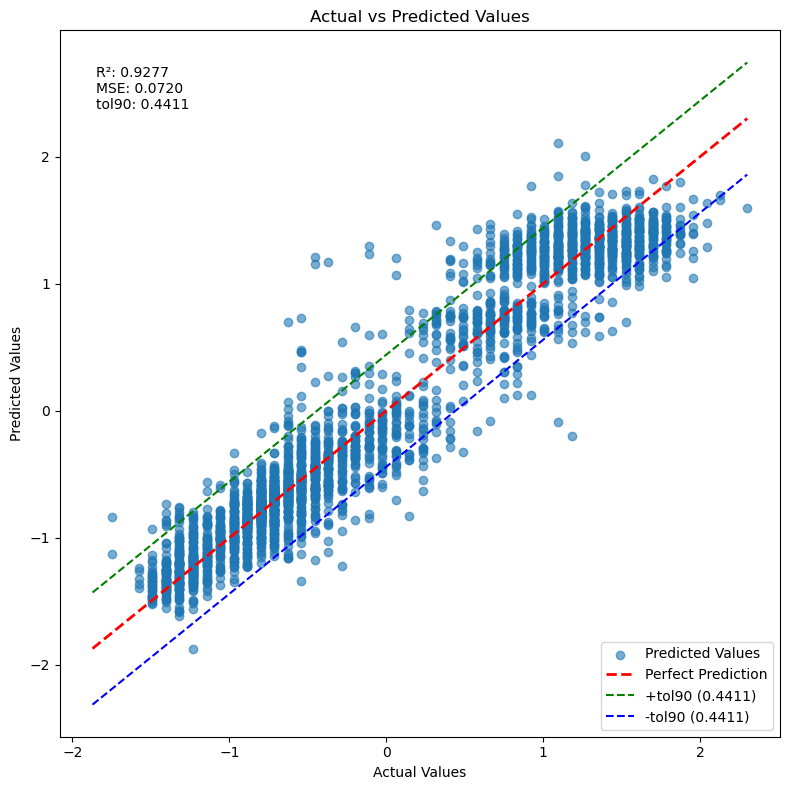

In [37]:
y_pred = ann.best_model.predict(test_scaled_df.drop(['steel_family', 'r_value'], axis=1)).flatten()
plot_actual_vs_predicted_ann(test_scaled_df['r_value'], y_pred)

GPR ------

In [42]:
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

def optimize_hyperparameters_gpr(X_train, y_train):

    
    # Define the parameter grid
    param_grid = {
        'kernel': [
            ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2)) * 
            Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + 
            WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))
        ]
    }
    
    gpr = GaussianProcessRegressor(normalize_y=True)
    
    # Grid search for the best hyperparameters
    grid_search = GridSearchCV(
        estimator=gpr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }


In [43]:
trained_models_gpr = train_optimized_family_models(train_scaled_df, model='gpr')

Optimizing Models: 100%|██████████| 3/3 [03:31<00:00, 70.40s/family]


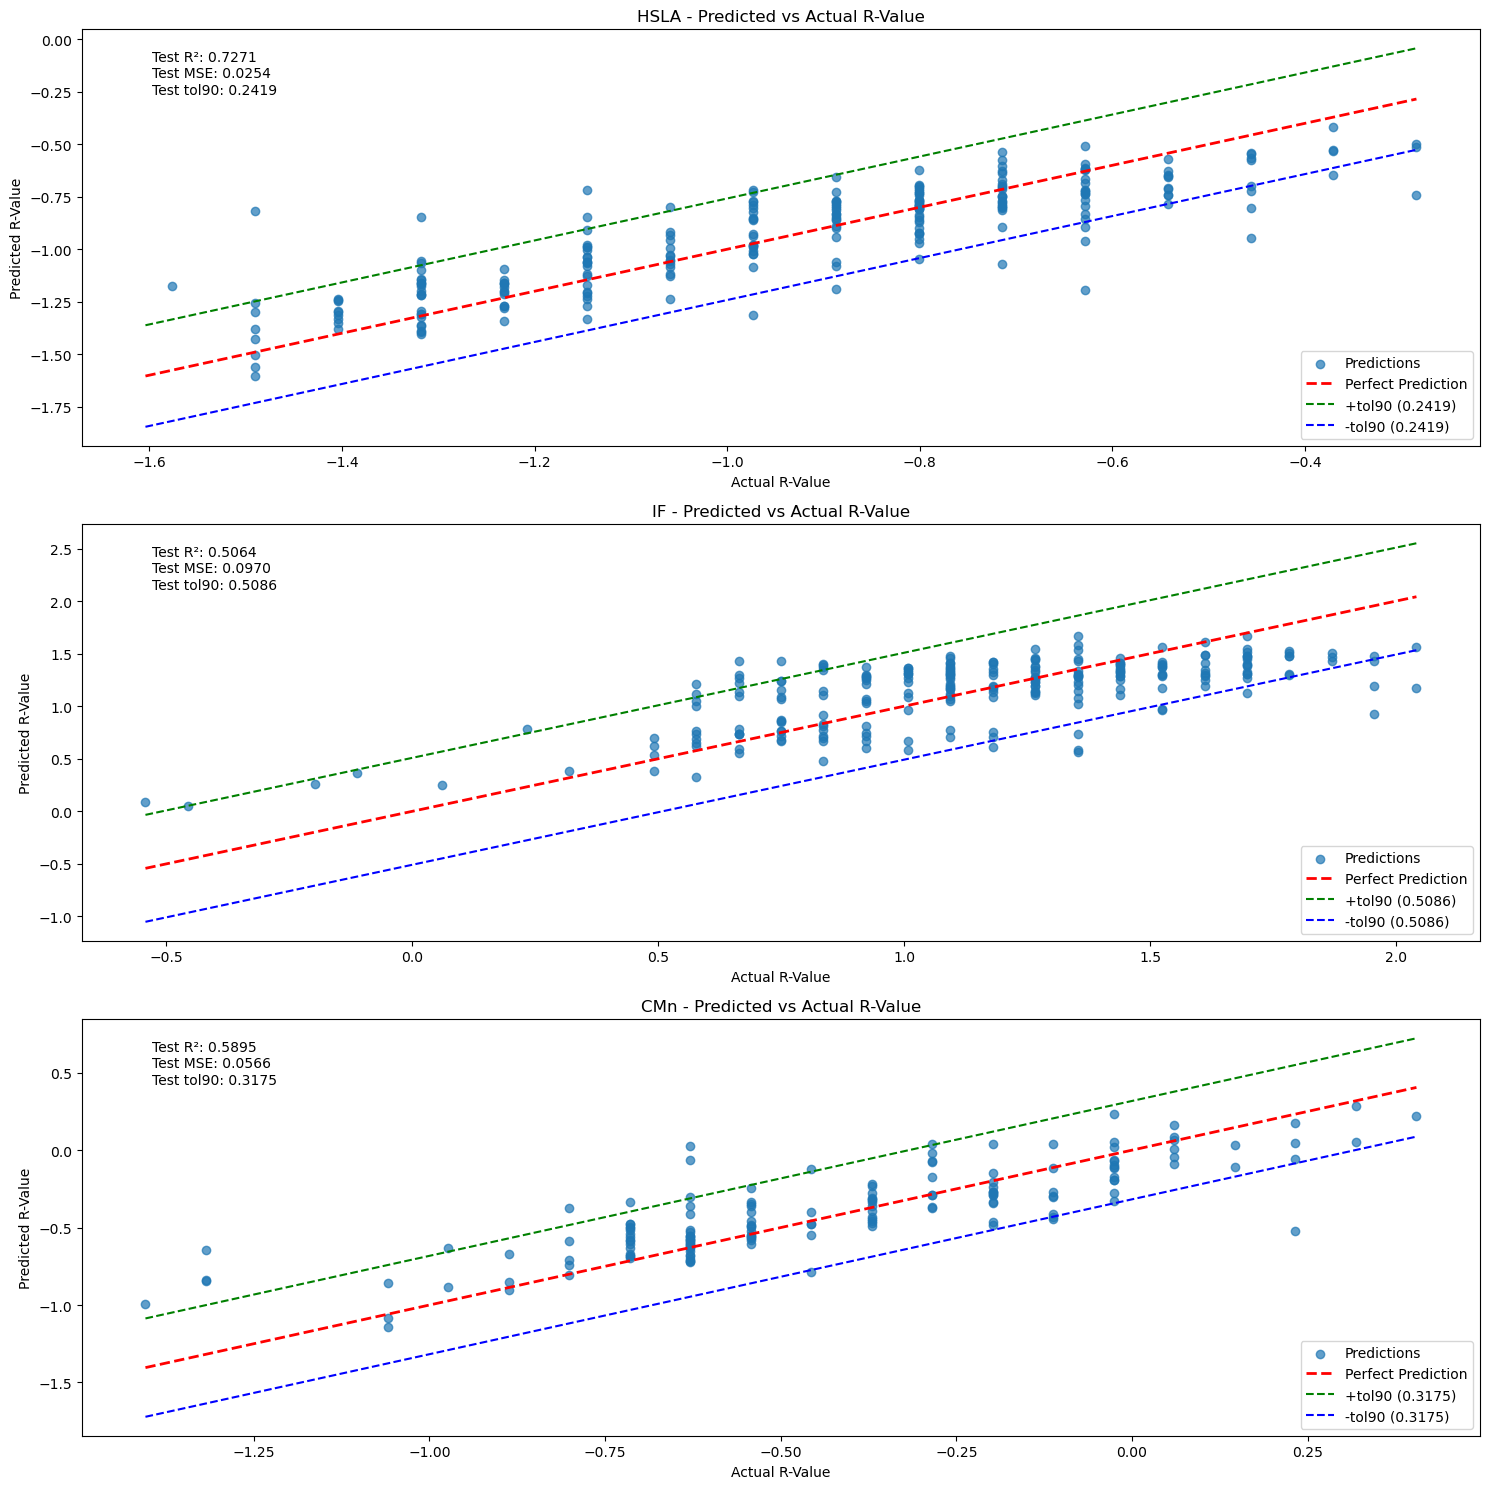

In [44]:
plot_predicted_vs_actual(trained_models_gpr, test_scaled_df)

KNN -----

In [47]:
from sklearn.neighbors import KNeighborsRegressor

def optimize_hyperparameters_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
        'leaf_size': [20, 30, 40, 50],    # Leaf size passed to BallTree or KDTree
        'weights': ['uniform', 'distance']  # Weight function used in prediction
    }
    
    # Initialize the KNN regressor
    knn = KNeighborsRegressor()
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

Optimizing Models: 100%|██████████| 3/3 [00:03<00:00,  1.07s/family]


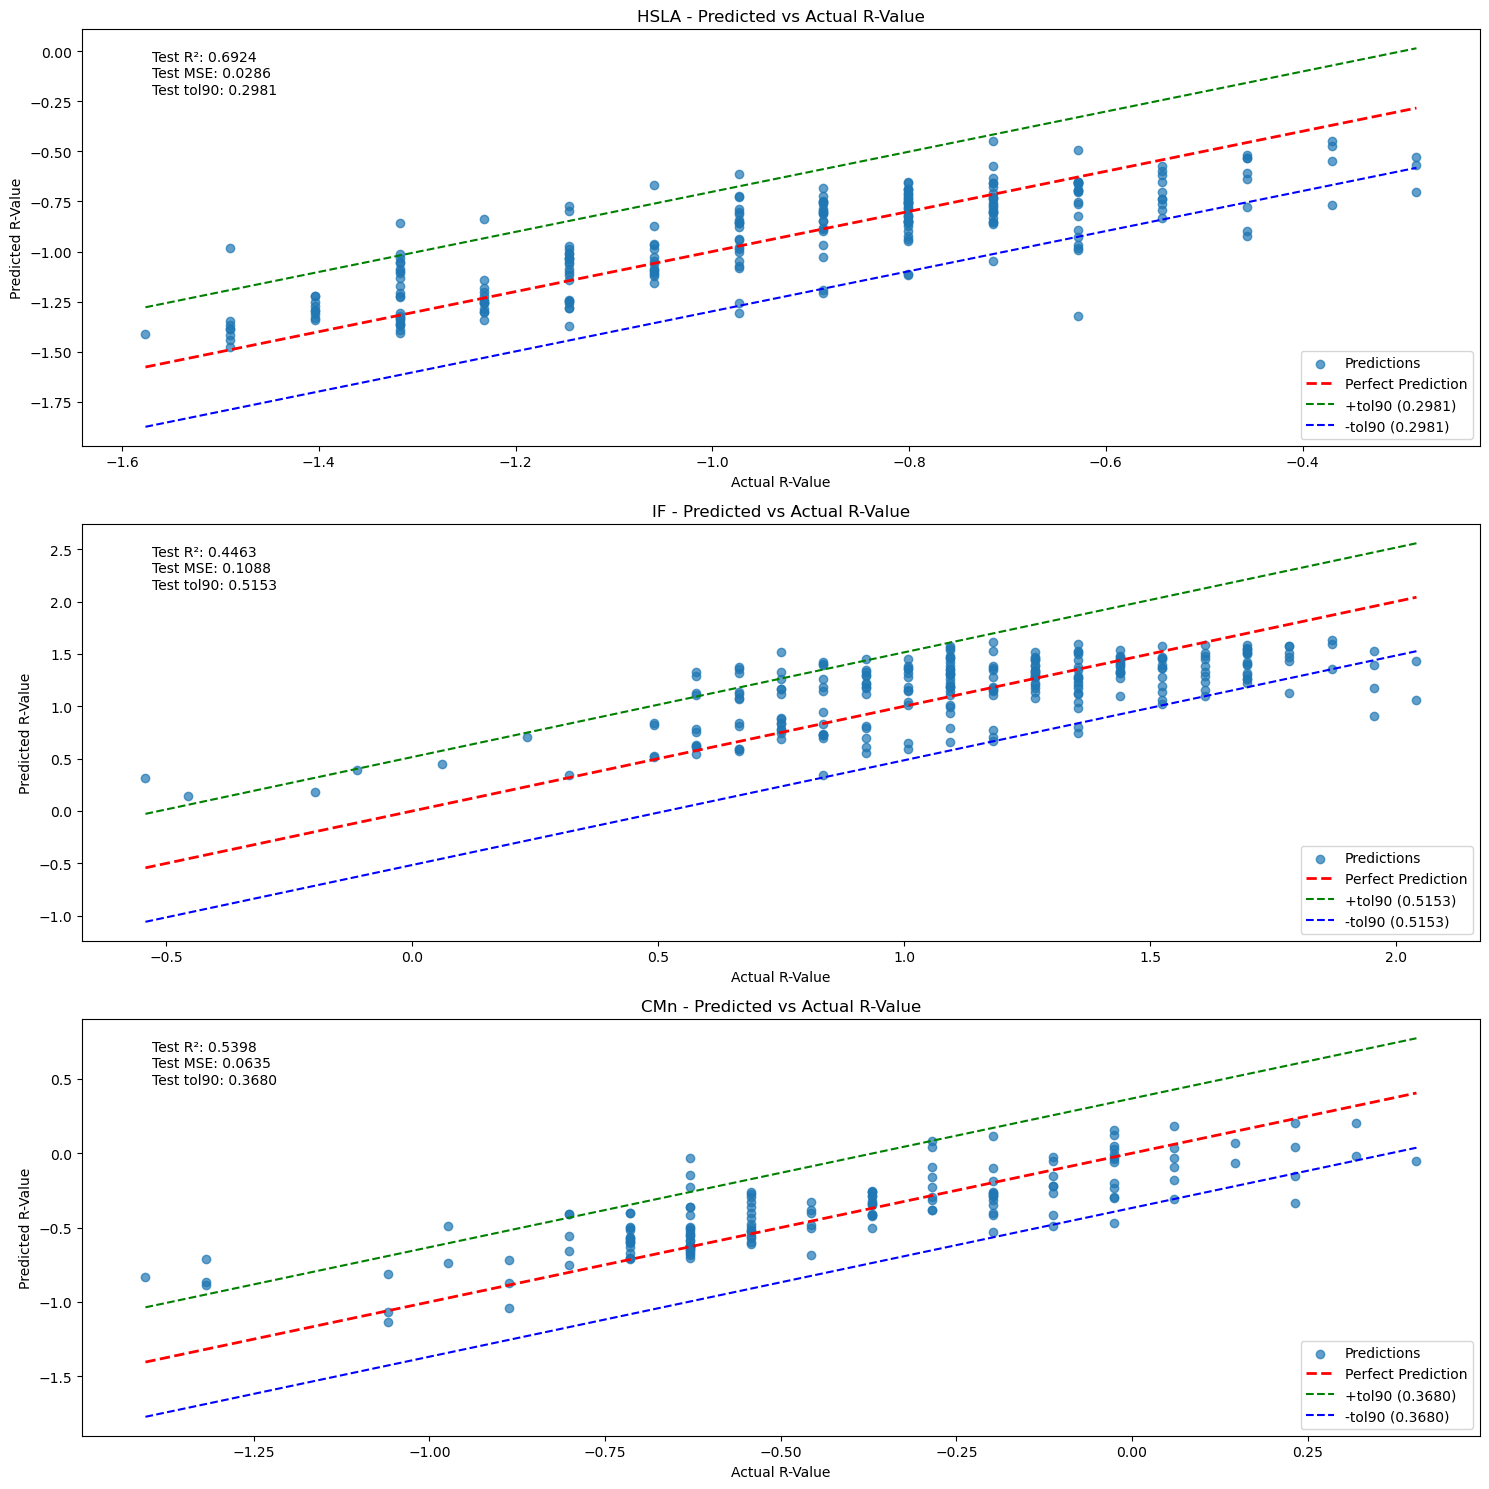

In [50]:
trained_models_knn = train_optimized_family_models(train_scaled_df, 'knn')
plot_predicted_vs_actual(trained_models_knn, test_scaled_df)

SVR ----

In [53]:
from sklearn.svm import SVR

def optimize_hyperparameters_svr(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],        # Regularization parameter
        'epsilon': [0.01, 0.1, 0.5, 1] # Epsilon in the epsilon-SVR model
    }
    
    # Initialize the SVR model
    svr = SVR(kernel='rbf')
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

Optimizing Models: 100%|██████████| 3/3 [00:21<00:00,  7.31s/family]


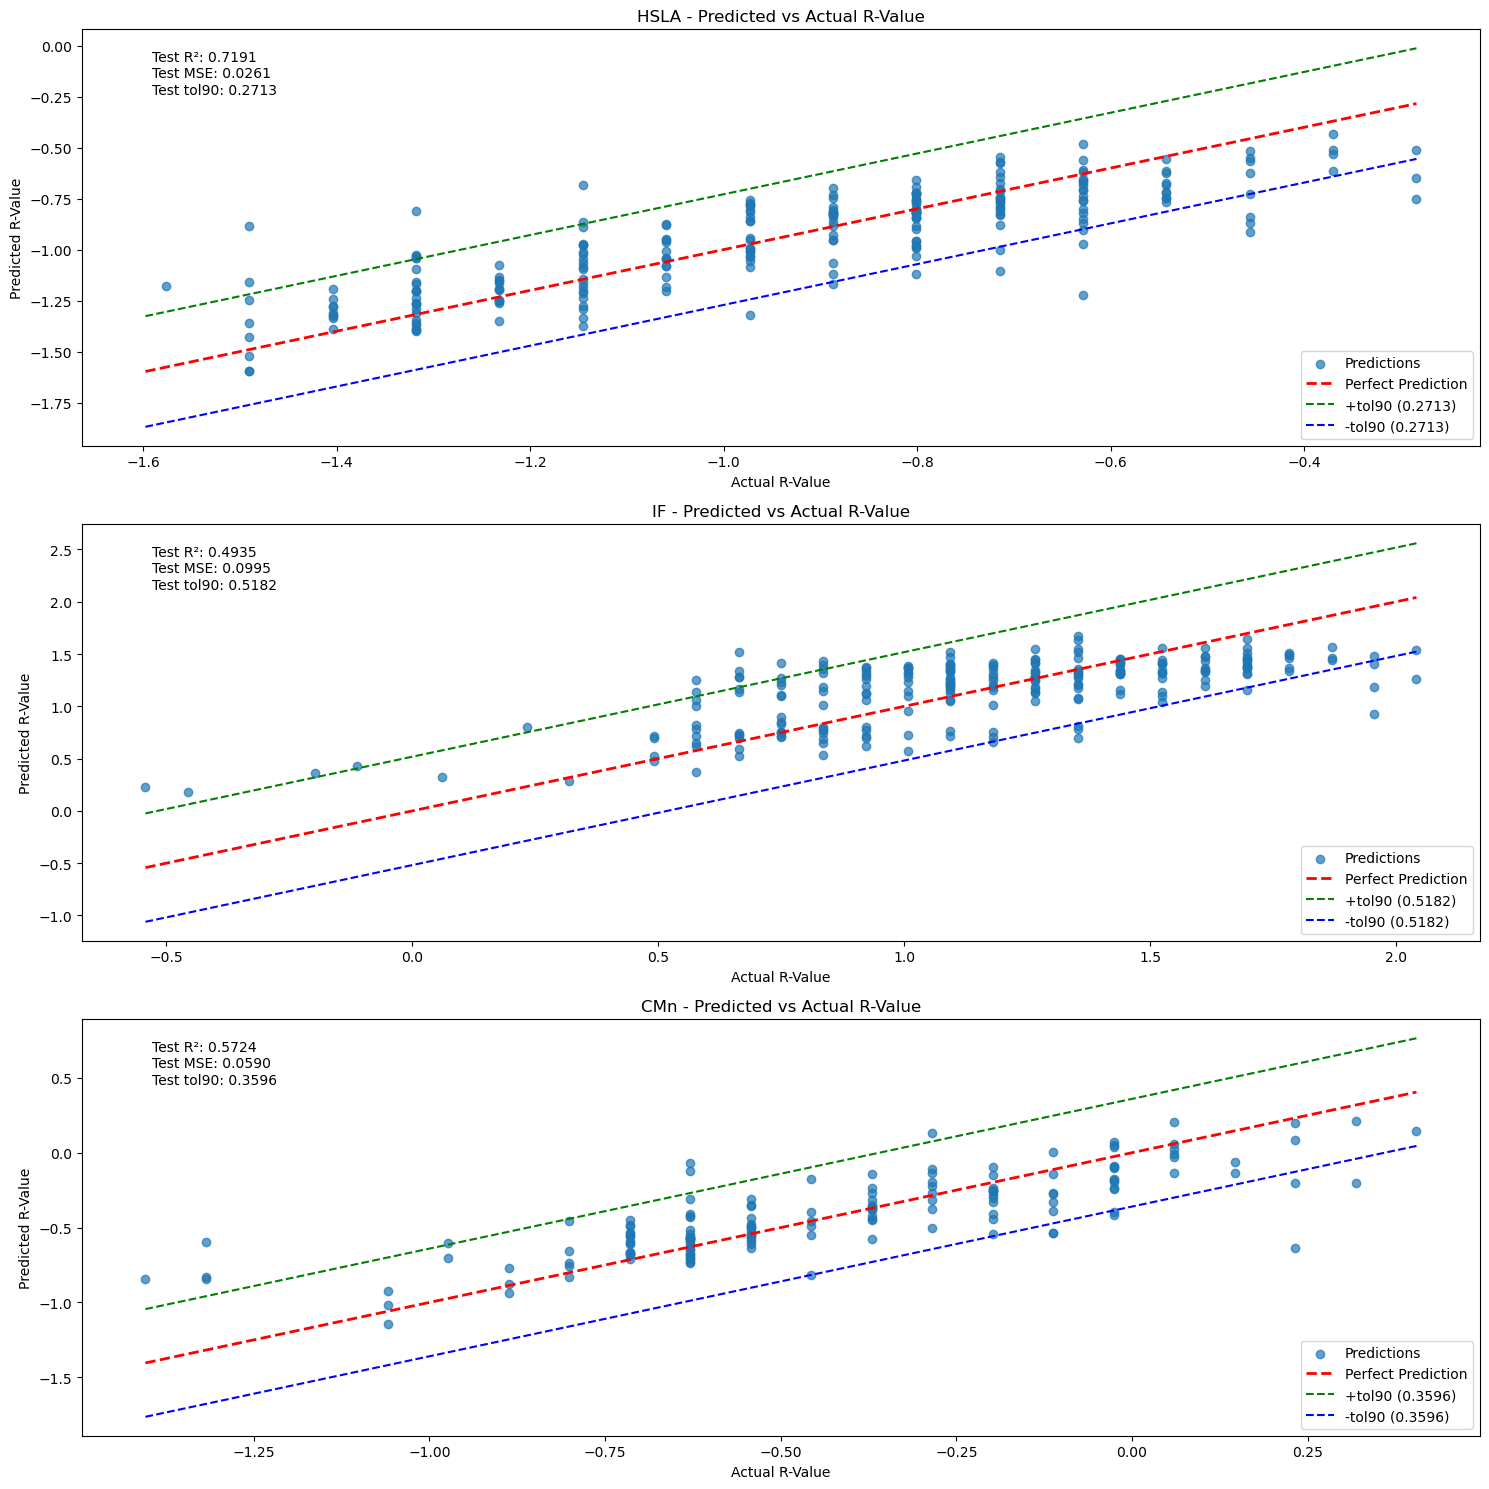

In [54]:
trained_models_svr = train_optimized_family_models(train_scaled_df, 'svr')
plot_predicted_vs_actual(trained_models_svr, test_scaled_df)

In [ ]:
from sklearn.linear_model import RidgeCV

def optimize_hyperparameters_ridge(X_train, y_train):
    # Define the range of alpha values to test
    alphas = [0.1, 1.0, 10.0, 100.0]
    
    # Initialize the RidgeCV model with the specified alphas
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    
    # Fit the model to the training data
    ridge_cv.fit(X_train, y_train)
    
    # Retrieve the best alpha and the corresponding model
    best_alpha = ridge_cv.alpha_
    best_model = ridge_cv
    
    # Calculate the mean cross-validated score for the best alpha
    best_score = -ridge_cv.cv_values_.mean()
    
    return {
        'best_params': {'alpha': best_alpha},
        'best_estimator': best_model,
        'best_score': best_score
    }

In [ ]:
trained_models_ridge = train_optimized_family_models(train_scaled_df, 'ridge')
plot_predicted_vs_actual(trained_models_ridge, test_scaled_df)